<a href="https://colab.research.google.com/github/Pushkarkv/Advanced-Tensorflow/blob/main/Training_Categorical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds
import matplotlib.ticker as mticker

In [2]:
train_data, info= tfds.load('fashion_mnist', split= 'train', with_info=True)
test_data= tfds.load('fashion_mnist', split='test')

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete5P49OZ/fashion_mnist-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete5P49OZ/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
class_names= ['T-shirt/top', 'Trouser/pants', 'Pullover shirt', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [4]:
def format_image(data):
  image= data['image']
  image= tf.reshape(image, [-1])
  image= tf.cast(image, 'float32')
  image= image/ 255.0
  return image, data['label']

In [5]:
train_data= train_data.map(format_image)
test_data= test_data.map(format_image)

In [6]:
batch_size=64
train= train_data.shuffle(buffer_size= 1024).batch(batch_size)
test=test_data.batch(batch_size= batch_size)

In [7]:
def base_model():
  inputs=tf.keras.Input(shape=(784,), name='digits')
  x= tf.keras.layers.Dense(64, activation='relu', name='dense_1')(inputs)
  x= tf.keras.layers.Dense(64, activation='relu', name='dense_2')(x)
  outputs= tf.keras.layers.Dense(10, activation='softmax', name='predictions')(x)
  model=tf.keras.Model(inputs= inputs, outputs= outputs)
  return model

In [8]:
optimizer= tf.keras.optimizers.Adam()
loss_object= tf.keras.losses.SparseCategoricalCrossentropy()

In [9]:
train_acc_metric= tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric= tf.keras.metrics.SparseCategoricalAccuracy()

In [10]:
def apply_gradient(optimizer, model, x, y):
  with tf.GradientTape() as tape:
    logits= model(x)
    loss_value= loss_object(y_true= y, y_pred= logits)
  
  gradients= tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))

  return logits, loss_value

In [11]:
def train_data_for_one_epoch():
  losses= []
  pbar= tqdm(total= len(list(enumerate(train))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}')
  for step, (x_batch_train, y_batch_train) in enumerate(train):
    logits, loss_value= apply_gradient(optimizer, model, x_batch_train, y_batch_train)
    losses.append(loss_value)
    train_acc_metric(y_batch_train, logits)
    pbar.set_description('Training loss for step %s: %.4f' %(int(step), float(loss_value)))
    pbar.update()
  return losses

In [12]:
def perform_validation():
  losses= []
  for x_val, y_val in test:
    val_logits= model(x_val)
    val_loss= loss_object(y_true= y_val, y_pred= val_logits)
    losses.append(val_loss)
    val_acc_metric(y_val, val_logits)
  return losses

In [13]:
model= base_model()

epochs=10
epochs_val_losses, epochs_train_losses= [], []
for epoch in range(epochs):
  print('Start of the epoch %d' %(epoch,))

  losses_train= train_data_for_one_epoch()
  train_acc= train_acc_metric.result()

  losses_val= perform_validation()
  val_acc= val_acc_metric.result()

  losses_train_mean= np.mean(losses_train)
  losses_val_mean= np.mean(losses_val)
  epochs_val_losses.append(losses_val_mean)
  epochs_train_losses.append(losses_train_mean)

  print('\n Epoch %s: Train loss: %.4f Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f' % (epoch, float(np.mean(losses_train)), float(np.mean(losses_val)),
                                                            float(train_acc), float(val_acc)))

  train_acc_metric.reset_states()
  val_acc_metric.reset_states()

Start of the epoch 0


Training loss for step 937: 0.1299: 100%|█████████▉| 937/938


 Epoch 0: Train loss: 0.5309 Validation Loss: 0.4511, Train Accuracy: 0.8166, Validation Accuracy 0.8414
Start of the epoch 1


Training loss for step 937: 0.2680: 100%|█████████▉| 937/938


 Epoch 1: Train loss: 0.3864 Validation Loss: 0.4076, Train Accuracy: 0.8606, Validation Accuracy 0.8569
Start of the epoch 2


Training loss for step 937: 0.2544: 100%|█████████▉| 937/938


 Epoch 2: Train loss: 0.3532 Validation Loss: 0.3766, Train Accuracy: 0.8706, Validation Accuracy 0.8670
Start of the epoch 3


Training loss for step 937: 0.2544: 100%|██████████| 938/938


 Epoch 3: Train loss: 0.3294 Validation Loss: 0.3728, Train Accuracy: 0.8795, Validation Accuracy 0.8680
Start of the epoch 4


Training loss for step 937: 0.3184: 100%|██████████| 938/938


 Epoch 4: Train loss: 0.3144 Validation Loss: 0.3586, Train Accuracy: 0.8854, Validation Accuracy 0.8754
Start of the epoch 5


Training loss for step 937: 0.1677: 100%|█████████▉| 937/938


 Epoch 5: Train loss: 0.2998 Validation Loss: 0.3448, Train Accuracy: 0.8890, Validation Accuracy 0.8782
Start of the epoch 6


Training loss for step 937: 0.2908: 100%|█████████▉| 937/938


 Epoch 6: Train loss: 0.2890 Validation Loss: 0.3533, Train Accuracy: 0.8925, Validation Accuracy 0.8768
Start of the epoch 7


Training loss for step 937: 0.2472: 100%|█████████▉| 937/938


 Epoch 7: Train loss: 0.2779 Validation Loss: 0.3586, Train Accuracy: 0.8968, Validation Accuracy 0.8772
Start of the epoch 8


Training loss for step 937: 0.0506: 100%|██████████| 938/938


 Epoch 8: Train loss: 0.2700 Validation Loss: 0.3576, Train Accuracy: 0.8993, Validation Accuracy 0.8763
Start of the epoch 9


Training loss for step 937: 0.1328: 100%|█████████▉| 937/938


 Epoch 9: Train loss: 0.2607 Validation Loss: 0.3636, Train Accuracy: 0.9020, Validation Accuracy 0.8775


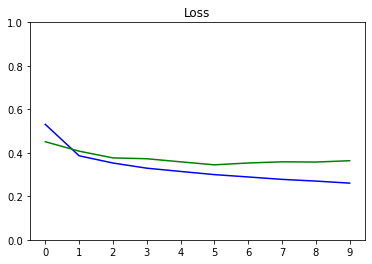

In [14]:
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0, ylim)
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.plot(train_metric, color='blue', label= metric_name)
  plt.plot(val_metric, color='green', label='val_'+ metric_name)

plot_metrics(epochs_train_losses, epochs_val_losses, 'Loss', 'Loss', ylim=1.0)

In [17]:
def display_images(image, predictions, labels, title, n):

  display_strings= [str(i) + '\n\n'+ str(j) for i, j in zip(predictions, labels)]

  plt.figure(figsize=(17,3))
  plt.title(title)
  plt.yticks([])
  plt.xticks([28* x+ 14 for x in range(n)], display_strings)
  plt.grid(None)
  image= np.reshape(image, [n, 28, 28])
  image= np.swapaxes(image, 0, 1)
  image= np.reshape(image, [28, 28* n])
  plt.imshow(image)

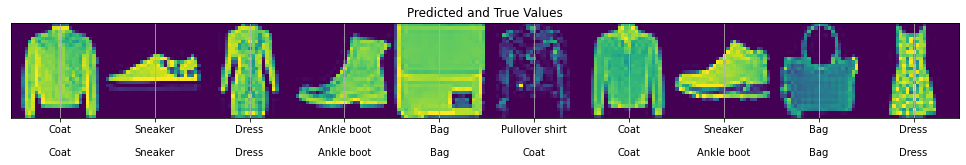

In [18]:
test_inputs= test_data.batch(batch_size= 1000001)
x_batches, y_pred_batches, y_true_batches= [], [], []

for x, y in test_inputs:
  y_pred= model(x)
  y_pred_batches= y_pred.numpy()
  y_true_batches= y.numpy()
  x_batches= x.numpy()

indexes=np.random.choice(len(y_pred_batches), size= 10)
images_to_plot= x_batches[indexes]
y_pred_to_plot= y_pred_batches[indexes]
y_true_to_plot= y_true_batches[indexes]

y_pred_labels= [class_names[np.argmax(sel_y_pred)] for sel_y_pred in y_pred_to_plot]
y_true_labels= [class_names[sel_y_true] for sel_y_true in y_true_to_plot]
display_images(images_to_plot, y_pred_labels, y_true_labels, 'Predicted and True Values', 10)